# Phân loại bệnh lá cà phê (healthy, cercospora, miner, mite, phoma, rust)

Notebook này: tiền xử lý dữ liệu, xây dựng pipeline tránh overfitting, tách train/validation/test từ thư mục `dataset/`, đánh giá trên validation & test, và lưu mô hình.

**Yêu cầu thư mục**:

- `dataset/` chứa 6 thư mục lớp: `healthy/`, `cercospora/`, `miner/`, `mite/`, `phoma/`, `rust/`.
Notebook này dùng **Vision Transformer (ViT-B/16)** qua `timm` để huấn luyện trên thư mục **`dataset/`** (6 lớp: `healthy, cercospora, miner, mite, phoma, rust`).
**Kỹ thuật chống overfitting sử dụng**:

- Augmentation: `RandomFlip`, `RandomRotation`, `RandomZoom`, `RandomContrast`.
- Regularization: `Dropout`, `L2` (weight decay) ở Dense head.
- Label Smoothing trong loss.
- EarlyStopping + ReduceLROnPlateau + ModelCheckpoint.
- Class weights (từ phân bố **train**).
- (Tuỳ chọn) MixUp nhẹ.

> Backbone: `EfficientNetV2B0`, input 224×224.
### Điểm cập nhật chính
- **Sửa cảnh báo**: dùng `torch.amp.autocast('cuda', ...)` thay cho API cũ `torch.cuda.amp.autocast(...)`.
- **Lọc ảnh hỏng/không hợp lệ** trước khi tạo Dataset (`PIL.Image.verify`).
- **Fallback OpenCV** khi PIL không mở được ảnh (`safe_open_image`).
- Bật `ImageFile.LOAD_TRUNCATED_IMAGES = True` để đọc các JPEG bị cắt ngang.
- Vẫn giữ **WeightedRandomSampler** (oversampling lớp ít như `mite`) + **MixUp** + **Label Smoothing** + **Cosine LR (warmup)** + **EarlyStopping**.

## 1) Cài đặt & Kiểm tra môi trường

In [ ]:
# For running on Google Colab
"""
from google.colab import drive
drive.mount('/content/drive')
!unzip -o -q /content/drive/MyDrive/dataset.zip -d dataset
DATADIR = 'dataset'
OUTPUT = '/content/drive/MyDrive/output_ViT'
print(DATADIR)
"""

Mounted at /content/drive
dataset


In [ ]:
# For running on Kaggle

DATADIR = '/kaggle/input/coffee-leaf'
OUTPUT = '/kaggle/working/'
print(DATADIR)
print(OUTPUT)


In [ ]:
#!pip install -q timm torch torchvision torchaudio scikit-learn==1.6.1 seaborn opencv-python

In [ ]:
import os, sys, random, pathlib, time, math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image, ImageFile
import shutil
ImageFile.LOAD_TRUNCATED_IMAGES = True  # đọc được một số JPEG bị cắt ngang
import cv2
import timm
from timm.data.mixup import Mixup
from timm.loss import SoftTargetCrossEntropy
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter # Tính tần suất lớp trong train
from tqdm.auto import tqdm # Import tqdm
import pickle
import datetime
# Mixed-precision: dùng API mới torch.amp.autocast
from torch.amp import autocast
# Scheduler: warmup (Linear) -> CosineAnnealingLR
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # 0=all, 1=INFO off, 2=INFO+WARN off, 3=INFO+WARN+ERR off
#os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
print('PyTorch:', torch.__version__)
print('Torch CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('⚠️ Chạy trên CPU — sẽ chậm hơn.')

print(f"CUDA Available on PC: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    t = torch.cuda.get_device_properties(0)
    print(f"Total VRAM: {t.total_memory / (1024**3):.2f} GB")

PyTorch: 2.8.0+cu126
Torch CUDA available: True
GPU: Tesla T4
CUDA Available on PC: True
Device count: 1
Current device: 0
Device name: Tesla T4
Total VRAM: 14.74 GB


## 2) Cấu hình & seed

In [ ]:
print(f"Bắt đầu quá trình lúc: {datetime.datetime.now()}")
# Seed tái lập
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Cấu hình
DATASET_DIR = Path(DATADIR)
assert DATASET_DIR.exists(), f'Không tìm thấy thư mục {DATASET_DIR.resolve()}'
MODEL = 'vit_base_patch16_384'
IMG_SIZE = 384
BATCH_SIZE = 64
EPOCHS = 20
BASE_LR = 3e-4
WEIGHT_DECAY = 0.05
WARMUP_EPOCHS = 2
LABEL_SMOOTHING = 0.1
MIXUP = True
MIXUP_ALPHA = 0.4
CUTMIX_ALPHA = 0.0
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.8, 0.1, 0.1
NUM_WORKERS = 0 if sys.platform.startswith('win') else max(2, os.cpu_count()//2)
PIN_MEMORY = torch.cuda.is_available()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Thiết bị:', DEVICE)
print('NUM_WORKERS:', NUM_WORKERS)
ALLOWED_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.webp', '.tiff', '.tif'}

Bắt đầu quá trình lúc: 2025-10-15 09:13:38.118834
Thiết bị: cuda
NUM_WORKERS: 2


## 3) Liệt kê dữ liệu & tách train/val/test (stratified theo lớp) + lọc ảnh lỗi

In [ ]:
# Lấy tên lớp theo thư mục
CLASS_NAMES = sorted([p.name for p in DATASET_DIR.iterdir() if p.is_dir()])
NUM_CLASSES = len(CLASS_NAMES)
print('Lớp:', CLASS_NAMES)
print('Số lớp:', NUM_CLASSES)

# Create directories for train, val, and test sets
output_data_dir = Path(OUTPUT + 'processed_dataset')
train_dir = output_data_dir / 'train'
val_dir = output_data_dir / 'val'
test_dir = output_data_dir / 'test'


In [ ]:
def list_images_by_class(root: Path):
    per_class = {}
    total = 0

    for cls in tqdm(CLASS_NAMES, desc="Danh sách hình ảnh"):
        cls_dir = root / cls
        files = [str(p) for p in cls_dir.rglob('*') if p.is_file() and p.suffix.lower() in ALLOWED_EXTS]
        per_class[cls] = sorted(files)
        total += len(files)
    return per_class, total

# Lọc ảnh hợp lệ bằng PIL.verify()
def is_valid_image(path):
    try:
        with Image.open(path) as im:
            im.verify()
        return True
    except Exception:
        return False

def filter_valid(paths, labels):
    keep_p, keep_l, bad = [], [], []

    for p, l in tqdm(zip(paths, labels), total=len(paths), desc="Đang lọc những bức ảnh không hợp lệ"):
        if is_valid_image(p):
            keep_p.append(p); keep_l.append(l)
        else:
            bad.append(p)
    if bad:
        print(f' Loại bỏ {len(bad)} tệp hỏng/không hợp lệ.')
    return keep_p, keep_l

per_class, total_images = list_images_by_class(DATASET_DIR)
print(f'Tổng ảnh dataset/: {total_images}')
for cls in CLASS_NAMES:
    print(f'  {cls}: {len(per_class[cls])} ảnh')

# Tách
rng = np.random.default_rng(SEED)
train_paths, val_paths, test_paths = [], [], []
train_labels, val_labels, test_labels = [], [], []
for cls_idx, cls in enumerate(CLASS_NAMES):
    files = per_class[cls]
    idx = np.arange(len(files)); rng.shuffle(idx)
    files = [files[i] for i in idx]
    n = len(files)
    n_train = int(n * TRAIN_RATIO)
    n_val = int(n * VAL_RATIO)
    n_test = n - n_train - n_val
    train_f = files[:n_train]
    val_f = files[n_train:n_train+n_val]
    test_f = files[n_train+n_val:]
    train_paths += train_f; train_labels += [cls_idx]*len(train_f)
    val_paths += val_f; val_labels += [cls_idx]*len(val_f)
    test_paths += test_f; test_labels += [cls_idx]*len(test_f)
print(f'\nTổng train: {len(train_paths)} | val: {len(val_paths)} | test: {len(test_paths)}')

# Lọc ảnh không hợp lệ khỏi từng split
train_paths, train_labels = filter_valid(train_paths, train_labels)
val_paths, val_labels     = filter_valid(val_paths,   val_labels)
test_paths, test_labels   = filter_valid(test_paths,  test_labels)
print(f'Sau lọc: train={len(train_paths)} | val={len(val_labels)} | test={len(test_paths)}')

for d in [train_dir, val_dir, test_dir]:
    d.mkdir(parents=True, exist_ok=True)
    for cls_name in CLASS_NAMES:
        (d / cls_name).mkdir(parents=True, exist_ok=True)

# Function to copy/symlink files to new directories
def save_split_to_dir(paths, labels, output_dir):

    print(f"Đường dẫn {output_dir.name}")
    for p, l_idx in tqdm(zip(paths, labels), total=len(paths), desc=f"Đang lưu vào {output_dir.name}"):
        file_path = Path(p)
        class_name = CLASS_NAMES[l_idx]
        dest_dir = output_dir / class_name
        # Using symlink to avoid copying large files, change to copy if needed
        dest_path = dest_dir / file_path.name
        if not dest_path.exists():
            try:
                # Use relative symlink if within the same filesystem, otherwise copy
                os.symlink(os.path.relpath(file_path, dest_dir), dest_path)
            except OSError:
                # Fallback to copy if symlink fails (e.g., different filesystems)
                shutil.copy2(file_path, dest_path)

print(f'Đang lưu dữ liệu đã được chia vào đường dẫn {output_data_dir}')
save_split_to_dir(train_paths, train_labels, train_dir)
save_split_to_dir(val_paths, val_labels, val_dir)
save_split_to_dir(test_paths, test_labels, test_dir)
print(f'Đã lưu train/val/test ảnh vào thư mục {output_data_dir}\n')
print(f"Tách và lọc ảnh hoàn tất lúc: {datetime.datetime.now()}")

Lớp: ['cercospora', 'healthy', 'miner', 'mite', 'phoma', 'rust']
Số lớp: 6


Danh sách hình ảnh:   0%|          | 0/6 [00:00<?, ?it/s]

Tổng ảnh dataset/: 72174
  cercospora: 7818 ảnh
  healthy: 22863 ảnh
  miner: 17489 ảnh
  mite: 167 ảnh
  phoma: 8028 ảnh
  rust: 15809 ảnh

Tổng train: 57737 | val: 7213 | test: 7224


Đang lọc những bức ảnh không hợp lệ:   0%|          | 0/57737 [00:00<?, ?it/s]

 Loại bỏ 88 tệp hỏng/không hợp lệ.


Đang lọc những bức ảnh không hợp lệ:   0%|          | 0/7213 [00:00<?, ?it/s]

 Loại bỏ 5 tệp hỏng/không hợp lệ.


Đang lọc những bức ảnh không hợp lệ:   0%|          | 0/7224 [00:00<?, ?it/s]

 Loại bỏ 11 tệp hỏng/không hợp lệ.
Sau lọc: train=57649 | val=7208 | test=7213
Đang lưu dữ liệu đã được chia vào đường dẫn processed_dataset
Đường dẫn train


Đang lưu vào train:   0%|          | 0/57649 [00:00<?, ?it/s]

Đường dẫn val


Đang lưu vào val:   0%|          | 0/7208 [00:00<?, ?it/s]

Đường dẫn test


Đang lưu vào test:   0%|          | 0/7213 [00:00<?, ?it/s]

Đã lưu train/val/test ảnh vào thư mục processed_dataset



## 4) Dataset & Transforms (augmentation) + fallback OpenCV

In [ ]:
# Chuẩn hoá theo ImageNet
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

# RandAugment nếu có, fallback ColorJitter nếu không
try:
    rand_aug = [transforms.RandAugment(num_ops=2, magnitude=9)]
except Exception as e:
    print('RandAugment không khả dụng, dùng ColorJitter thay thế.')
    rand_aug = [transforms.ColorJitter(0.2,0.2,0.2,0.1)]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    *rand_aug,
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

eval_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

def safe_open_image(path):
    # Thử PIL trước
    try:
        img = Image.open(path).convert('RGB')
        return img
    except Exception:
        pass
    # Fallback OpenCV
    img_cv = cv2.imread(path, cv2.IMREAD_COLOR)
    if img_cv is None:
        raise ValueError(f'Không thể đọc ảnh: {path}')
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img_cv)

class ImageDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        y = self.labels[idx]
        try:
            img = safe_open_image(p)
        except Exception as e:
            # Nếu vẫn lỗi hiếm gặp, bỏ qua ảnh này bằng cách lấy ảnh kế tiếp
            # (thực tế có thể chọn ảnh placeholder, ở đây đơn giản là raise để thấy lỗi)
            raise e
        if self.transform:
            img = self.transform(img)
        return img, y

# Update: Load data from the processed_dataset directories
output_data_dir = Path(OUTPUT + 'processed_dataset')
train_dir = output_data_dir / 'train'
val_dir = output_data_dir / 'val'
test_dir = output_data_dir / 'test'

# Function to list images and labels from a directory structure
def list_images_from_dir(directory):
    paths = []
    labels = []
    for cls_idx, cls_name in enumerate(CLASS_NAMES):
        cls_dir = directory / cls_name
        files = [str(p) for p in cls_dir.rglob('*') if p.is_file()]
        paths.extend(files)
        labels.extend([cls_idx] * len(files))
    return paths, labels

train_paths, train_labels = list_images_from_dir(train_dir)
val_paths, val_labels = list_images_from_dir(val_dir)
test_paths, test_labels = list_images_from_dir(test_dir)

train_ds = ImageDataset(train_paths, train_labels, train_tfms)
val_ds = ImageDataset(val_paths, val_labels, eval_tfms)
test_ds = ImageDataset(test_paths, test_labels, eval_tfms)
print('Số mẫu train/val/test:', len(train_ds), len(val_ds), len(test_ds))

Tách và lọc ảnh hoàn tất lúc: 2025-10-15 09:14:32.504500
Số mẫu train/val/test: 57649 7208 7213


## 5) Xử lý mất cân bằng: WeightedRandomSampler (oversampling lớp nhỏ)

In [ ]:
cnt = Counter(train_labels)
print('Phân bố train:', {CLASS_NAMES[k]: v for k,v in cnt.items()})

# Trọng số mẫu = 1 / tần suất lớp
class_freq = np.array([cnt.get(i, 0) for i in range(NUM_CLASSES)], dtype=np.float64)
class_freq[class_freq==0] = 1
class_weight = 1.0 / class_freq
sample_weights = np.array([class_weight[y] for y in train_labels], dtype=np.float64)
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
print('Đã tạo WeightedRandomSampler (oversampling lớp ít).')

Phân bố train: {'cercospora': 6254, 'healthy': 18204, 'miner': 13991, 'mite': 133, 'phoma': 6422, 'rust': 12645}
Đã tạo WeightedRandomSampler (oversampling lớp ít).


## 6) DataLoaders + MixUp

In [ ]:
# MixUp setup
mixup_fn = None
if MIXUP:
    mixup_fn = Mixup(mixup_alpha=MIXUP_ALPHA, cutmix_alpha=CUTMIX_ALPHA,
                     prob=1.0, switch_prob=0.0, mode='batch',
                     label_smoothing=LABEL_SMOOTHING, num_classes=NUM_CLASSES)
    print(' MixUp đang bật')
else:
    print('⚠️ MixUp tắt')

def collate_fn(batch):
    imgs, labels = list(zip(*batch))
    imgs = torch.stack(imgs, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)
    if mixup_fn is not None:
        imgs, labels = mixup_fn(imgs, labels)
    return imgs, labels

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          drop_last=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
len(train_loader), len(val_loader), len(test_loader)

 MixUp đang bật


(900, 113, 113)

## 7) Khởi tạo ViT-B/16 (timm) + optimizer, loss, scheduler

In [ ]:
model = timm.create_model(MODEL, pretrained=True, num_classes=NUM_CLASSES)
model.to(DEVICE)
print('Số tham số huấn luyện:', sum(p.numel() for p in model.parameters() if p.requires_grad))

# Loss: nếu MixUp -> SoftTargetCrossEntropy; nếu không -> CrossEntropy có label smoothing
if MIXUP:
    criterion = SoftTargetCrossEntropy()
else:
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

optimizer = optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)

main_scheduler = CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS - WARMUP_EPOCHS))
if WARMUP_EPOCHS > 0:
    warmup_scheduler = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=WARMUP_EPOCHS)
    scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, main_scheduler], milestones=[WARMUP_EPOCHS])
else:
    scheduler = main_scheduler

scaler = torch.amp.GradScaler('cuda', enabled=torch.cuda.is_available())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

Số tham số huấn luyện: 86095110


## 8) Vòng lặp huấn luyện + EarlyStopping + Checkpoint (đã dùng autocast API mới)

In [ ]:
def accuracy_from_logits(logits, targets):
    if logits.ndim == 2 and targets.ndim == 2:
        preds = logits.argmax(dim=1)
        y = targets.argmax(dim=1)
    else:
        preds = logits.argmax(dim=1)
        y = targets
    return (preds == y).float().mean().item()

def train_one_epoch(epoch):
    model.train()
    total_loss, total_acc = 0.0, 0.0
    n_batches = 0
    print(f"\nBắt đầu epoch {epoch:02d}/{EPOCHS} lúc: {datetime.datetime.now()}")

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch:02d}/{EPOCHS} [TRAIN]", leave=False)
    for imgs, labels in progress_bar:
        imgs = imgs.to(DEVICE, non_blocking=True)
        # Labels are already handled by collate_fn (Mixup or not)
        labels = labels.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda', enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, labels) # Use the globally defined criterion
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        acc = accuracy_from_logits(logits.detach(), labels.detach())
        total_loss += loss.item()
        total_acc += acc
        n_batches += 1

        # Update progress bar with current loss and accuracy
        progress_bar.set_postfix(loss=loss.item(), acc=acc)

    return total_loss / max(1,n_batches), total_acc / max(1,n_batches)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss, total_acc, n_batches = 0.0, 0.0, 0
    # Always use CrossEntropyLoss with label smoothing for evaluation as targets are integer labels
    eval_criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

    progress_bar = tqdm(loader, desc="[EVAL]", leave=False)
    for imgs, labels in progress_bar:
        imgs = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE)
        with autocast('cuda', enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = eval_criterion(logits, labels) # Use eval_criterion here
        acc = accuracy_from_logits(logits, labels)
        total_loss += loss.item()
        total_acc += acc
        n_batches += 1
        # Update progress bar with current loss and accuracy
        progress_bar.set_postfix(loss=loss.item(), acc=acc)

    return total_loss / max(1,n_batches), total_acc / max(1,n_batches)

best_val_acc = -1.0
patience, patience_count = EPOCHS, 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
ckpt_dir = Path(OUTPUT + 'checkpoints'); ckpt_dir.mkdir(parents=True, exist_ok=True)
best_ckpt_path = ckpt_dir / 'best_vit_b16.pth'

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(epoch)
    val_loss, val_acc = evaluate(val_loader)
    scheduler.step()
    history['train_loss'].append(tr_loss); history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
    dt = time.time()-t0
    print(f'Epoch {epoch:02d}/{EPOCHS} | train_loss={tr_loss:.4f} acc={tr_acc:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f} | {dt:.1f}s')
    # EarlyStopping & Checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_count = 0
        torch.save({'model': model.state_dict(), 'epoch': epoch, 'val_acc': val_acc}, best_ckpt_path)
        print('***** | ****** Lưu best model:', best_ckpt_path)
    else:
        patience_count += 1
        if patience_count >= patience:
            print(' EarlyStopping kích hoạt.')
            break

# Lưu lịch sử
with open(OUTPUT + 'training_history.pkl', 'wb') as f:
    pickle.dump(history, f)
print(' Huấn luyện xong. Lịch sử lưu vào training_history.pkl')


Starting epoch 01/3


Epoch 01/3 [TRAIN]:   0%|          | 0/900 [00:00<?, ?it/s]

[EVAL]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 01/3 | train_loss=0.7706 acc=0.9192 | val_loss=0.4719 acc=0.9776 | 1549.5s
***** | ****** Lưu best model: checkpoints/best_vit_b16.pth

Starting epoch 02/3


Epoch 02/3 [TRAIN]:   0%|          | 0/900 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dd87b4e1d00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1610, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.12/threading.py", line 1146, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dd87b4e1d00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  Exception ignored in:  <function _MultiProcess

[EVAL]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 02/3 | train_loss=0.7950 acc=0.9174 | val_loss=0.4913 acc=0.9716 | 1531.2s

Starting epoch 03/3


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 03/3 [TRAIN]:   0%|          | 0/900 [00:00<?, ?it/s]

[EVAL]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 03/3 | train_loss=0.8259 acc=0.8995 | val_loss=0.4985 acc=0.9715 | 1520.6s
✅ Huấn luyện xong. Lịch sử lưu vào training_history.pkl


## 9) Biểu đồ Loss/Accuracy

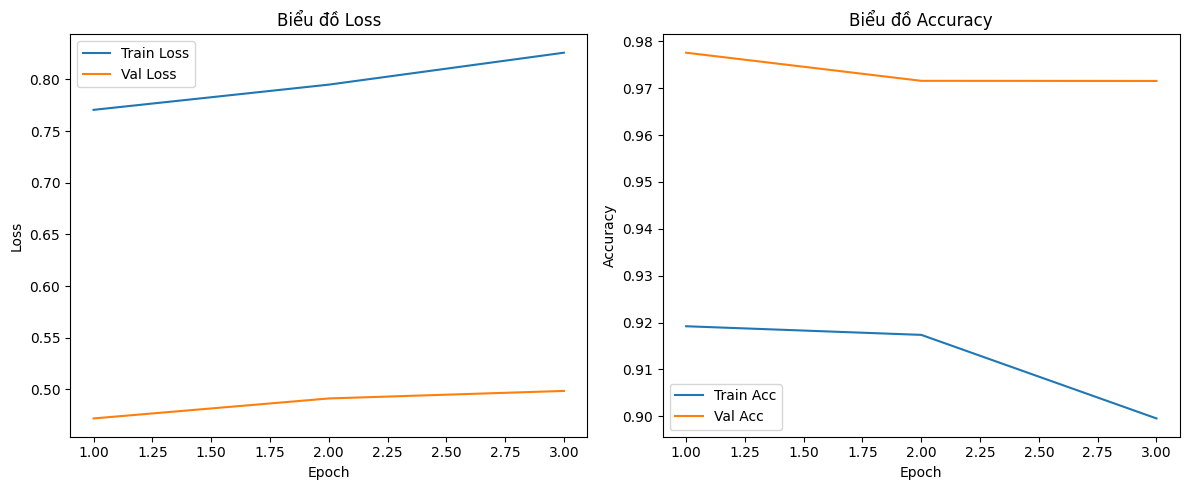

Biểu đồ Loss và Accuracy đã được lưu tại loss_accuracy_plot.png


<Figure size 640x480 with 0 Axes>

In [ ]:
with open(OUTPUT + 'training_history.pkl', 'rb') as f:
    history = pickle.load(f)
epochs_ran = range(1, len(history['train_loss'])+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_ran, history['train_loss'], label='Train Loss')
plt.plot(epochs_ran, history['val_loss'], label='Val Loss')
plt.title('Biểu đồ Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs_ran, history['train_acc'], label='Train Acc')
plt.plot(epochs_ran, history['val_acc'], label='Val Acc')
plt.title('Biểu đồ Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

# Save the plots
plt.savefig(OUTPUT + 'loss_accuracy_plot.png')
print(f"Biểu đồ Loss và Accuracy đã được lưu tại {OUTPUT}loss_accuracy_plot.png")

## 10) Đánh giá trên Test + Báo cáo chi tiết

Báo cáo phân loại (Test):
              precision    recall  f1-score   support

  cercospora     0.9911    0.9974    0.9943       783
     healthy     0.9955    0.9723    0.9838      2277
       miner     0.9989    0.9966    0.9977      1750
        mite     0.4571    0.8889    0.6038        18
       phoma     0.9816    0.9950    0.9883       804
        rust     0.9576    0.9722    0.9648      1581

    accuracy                         0.9832      7213
   macro avg     0.8970    0.9704    0.9221      7213
weighted avg     0.9846    0.9832    0.9837      7213

Báo cáo phân loại đã được lưu tại classification_report.txt


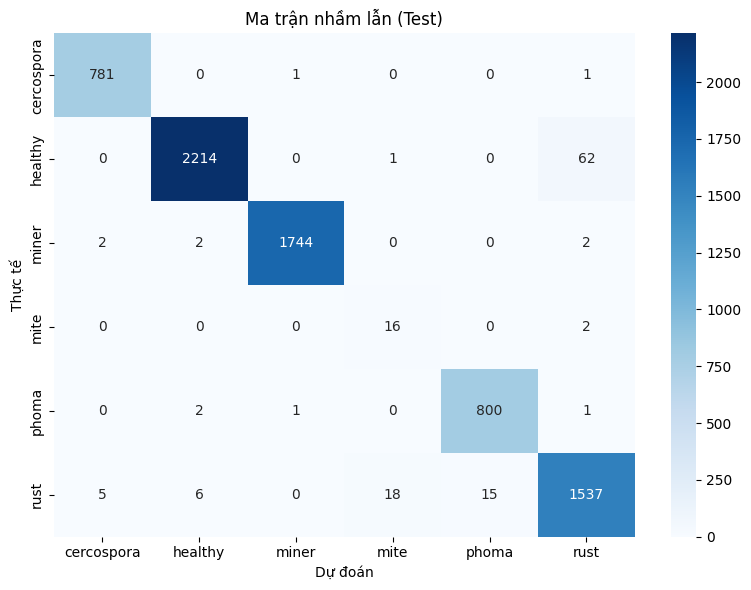

Ma trận nhầm lẫn đã được lưu tại confusion_matrix.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Tải best model
best_ckpt_path = Path(OUTPUT + 'checkpoints/best_vit_b16.pth')
assert best_ckpt_path.exists(), 'Chưa có best checkpoint'
ckpt = torch.load(best_ckpt_path, map_location=DEVICE)
model.load_state_dict(ckpt['model'])
model.eval()

# Evaluate
@torch.no_grad()
def predict_loader(loader):
    y_true, y_pred = [], []
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE)
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy().tolist()
        y_pred += preds
        y_true += labels.numpy().tolist()
    return y_true, y_pred

y_true, y_pred = predict_loader(test_loader)
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4)
print('Báo cáo phân loại (Test):')
print(report)

# Save classification report
report_path = Path(OUTPUT + 'classification_report.txt')
with open(report_path, 'w') as f:
    f.write(report)
print(f"Báo cáo phân loại đã được lưu tại {report_path}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Ma trận dự đoán (Test)'); plt.xlabel('Dự đoán'); plt.ylabel('Thực tế')
plt.tight_layout(); plt.show()

# Save confusion matrix plot
cm_path = Path(OUTPUT + 'confusion_matrix.png')
plt.savefig(cm_path)
print(f"Ma trận dự đoán đã được lưu tại {cm_path}")

## 11) Lưu mô hình cuối cùng

In [ ]:
save_dir = Path(OUTPUT + 'saved_model'); save_dir.mkdir(parents=True, exist_ok=True)
final_path = save_dir / 'vit_b16_plant_disease.pth'
torch.save({'model': model.state_dict(), 'classes': CLASS_NAMES}, final_path)
print(' Đã lưu mô hình vào', final_path)

print(f"Kết thúc quá trình lúc: {datetime.datetime.now()}")

✅ Đã lưu mô hình vào saved_model/vit_b16_plant_disease.pth
Kết thúc quá trình lúc: 2025-10-15 10:36:16.532917


---
### Gợi ý tối ưu thêm
- Thử `MIXUP_ALPHA=0.3~0.4` nếu còn overfitting.
- Tăng `IMG_SIZE` lên 256/288 nếu GPU cho phép (đổi model sang `vit_base_patch16_384` nếu muốn 384).
- Số epoch có thể 30–50 để khai thác ViT tốt hơn (với Cosine LR), nhưng theo yêu cầu đang đặt là 20.
- Nếu bạn muốn **fine-tune theo 2 giai đoạn** (warmup head rồi mới unfreeze), có thể thay đổi: freeze tất cả, train head 3–5 epochs, sau đó unfreeze toàn bộ và giảm LR.
